In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
sns.set()
%matplotlib inline

In [5]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))
# pd.set_option('display.float_format',lambda x: '%.4f' % x)

The [Chicago Historical temperature data came from NOAA](https://www.ncdc.noaa.gov/cdo-web/datasets). I pulled in data from 4 separate weather stations around Chicago. Chicago is not large enough that there will be massive monthly temperature differences between different weather stations in the city, and all weather stations in the NOAA database are reputable (ie calibrate their instruments, so same-year comparisons should have the same accuracy, and measurements shouldn't be off by more than 1 degree F.

In [7]:
CSV_PATH = os.path.join('data', 'weather', 'chicago_hist.csv')
chi = pd.read_csv(CSV_PATH, encoding='latin1', parse_dates=['DATE']) 
chi.head()

,STATION,NAME,DATE,CDSD,DSND,DSNW,EMNT,EMSD,EMSN,EMXP,EMXT,HDSD,PRCP,SNOW,TAVG,TMAX,TMIN
0,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",1928-03-01,NaN,1.0,2.0,8.0,1.0,4.2,0.36,77.0,NaN,1.39,6.0,36.2,44.8,27.5
1,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",1928-04-01,NaN,0.0,0.0,21.0,0.0,0.6,0.90,74.0,NaN,2.01,0.7,44.0,53.7,34.2
2,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",1928-05-01,NaN,0.0,0.0,31.0,0.0,0.0,0.76,89.0,NaN,1.69,0.0,58.2,70.1,46.2
3,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",1928-06-01,NaN,0.0,0.0,41.0,0.0,0.0,2.56,87.0,NaN,6.64,0.0,63.0,72.9,53.0
4,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",1928-11-01,NaN,0.0,0.0,19.0,0.0,0.1,1.29,68.0,NaN,4.06,0.1,40.6,47.2,33.9


In [8]:
temp_chi = chi[['DATE', 'TAVG', 'NAME']]
temp_chi.head()

,DATE,TAVG,NAME
0,1928-03-01,36.2,"CHICAGO MIDWAY AIRPORT 3 SW, IL US"
1,1928-04-01,44.0,"CHICAGO MIDWAY AIRPORT 3 SW, IL US"
2,1928-05-01,58.2,"CHICAGO MIDWAY AIRPORT 3 SW, IL US"
3,1928-06-01,63.0,"CHICAGO MIDWAY AIRPORT 3 SW, IL US"
4,1928-11-01,40.6,"CHICAGO MIDWAY AIRPORT 3 SW, IL US"


In [9]:
temp_chi = temp_chi.pivot(index='DATE', columns='NAME')
temp_chi.head()

TAVG                            \
NAME       CHICAGO MIDWAY AIRPORT 3 SW, IL US CHICAGO UNIVERSITY, IL US   
DATE                                                                      
1893-11-01                                NaN                       NaN   
1893-12-01                                NaN                       NaN   
1894-01-01                                NaN                       NaN   
1894-02-01                                NaN                       NaN   
1894-03-01                                NaN                       NaN   

                                                               
NAME       CHICAGO WEATHER BUREAU CITY 2, IL US JOLIET, IL US  
DATE                                                           
1893-11-01                                  NaN          37.9  
1893-12-01                                  NaN          28.5  
1894-01-01                                  NaN          30.7  
1894-02-01                                  NaN          24.7  
1894-03-01                                  NaN          45.6

In [10]:
temp_chi = pd.DataFrame(temp_chi.mean(axis=1))
temp_chi.columns = ['Avg_Temp']

In [11]:
temp_chi.head()

,Avg_Temp
DATE,
1893-11-01,37.9
1893-12-01,28.5
1894-01-01,30.7
1894-02-01,24.7
1894-03-01,45.6


**Now that we have a continuous series of Chicago temperature data, we can plot that data and look for trends.** 

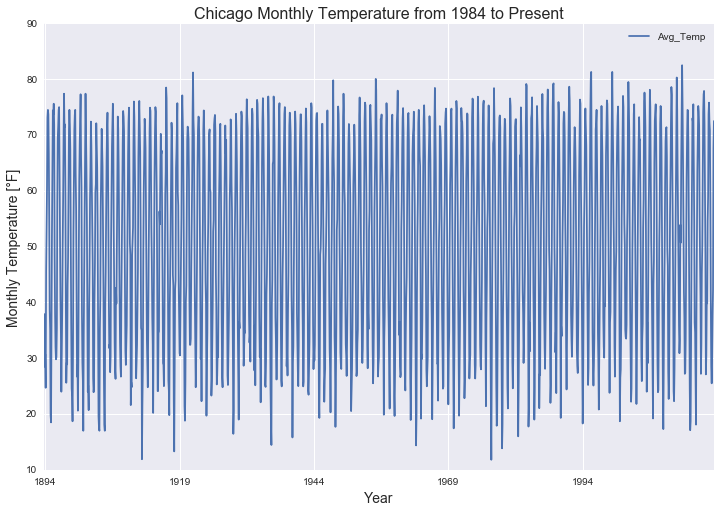

In [12]:
ax = temp_chi.plot(figsize=(12,8))
ax.set_title('Chicago Monthly Temperature from 1984 to Present', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Monthly Temperature [°F]', fontsize=14)

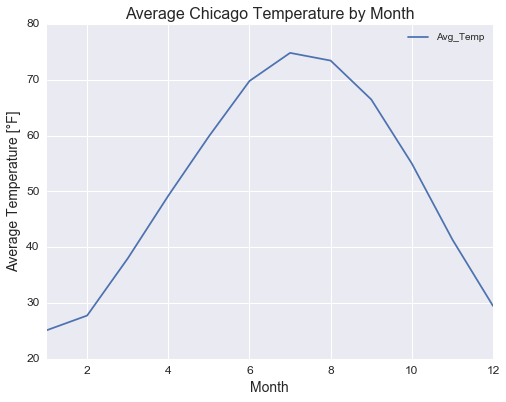

In [13]:
chi_temp_by_month = temp_chi.groupby(temp_chi.index.month).mean()
ax = chi_temp_by_month.plot(fontsize=12, figsize=(8,6))
ax.set_title('Average Chicago Temperature by Month', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Average Temperature [°F]', fontsize=14)

**Our data is monthly, and as you can see from the two plots below, the average monthly temperature cycles every year. This is what we expect, but all that variation makes it hard to determine if any significant trends are present. To We'll decompose our temperature data into 3 separate time-series; trend, seasonality, and residual noise. **

In [14]:
def decomposition_to_df(decomp):
    """Helper Method that makes a DataFrame from decomposition data.
    Args: 
        decomp:   the DecomposeResult returned from statsmodels
                seasonal_decompose() method.
    Returns:
        A pandas dataframe containing 3 series."""
    trend = decomp.trend
    trend.columns = ['Trend']
    seasonality = decomp.seasonal
    seasonality.columns = ['Seasonality']
    residuals = decomp.resid
    residuals.columns = ['Residuals']
    return trend.join(seasonality).join(residuals)

In [15]:
decomposition = sm.tsa.seasonal_decompose(temp_chi)
decomposed = decomposition_to_df(decomposition)

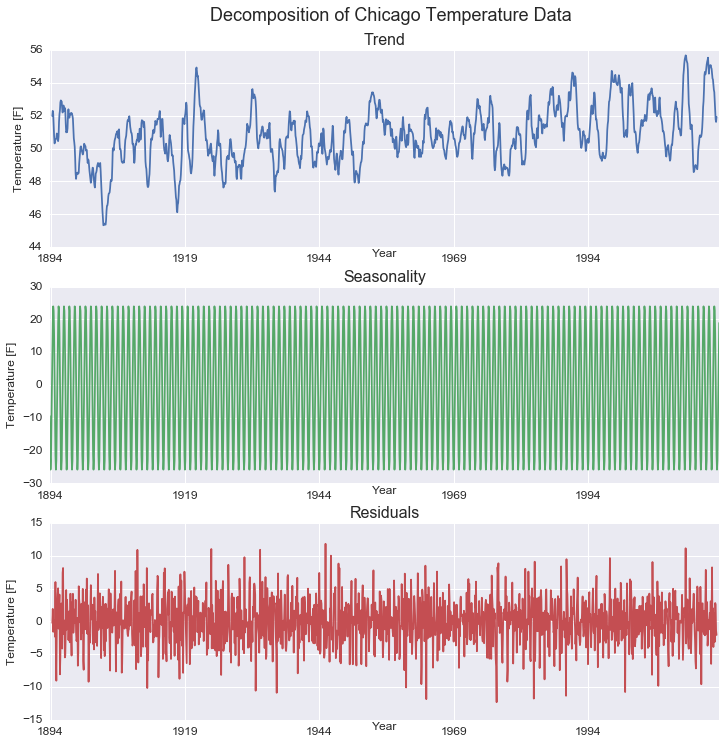

In [16]:
ax = decomposed.plot(subplots=True,
                     figsize=(12, 12), 
                     fontsize=12, 
                     sharey=False, 
                     sharex=False, 
                     legend=False)

for i in range(len(decomposed.columns.values)):
    ax[i].set_title(decomposed.columns.values[i], fontsize=16)
    ax[i].set_ylabel('Temperature [F]', fontsize=12)
    ax[i].set_xlabel('Year', fontsize=12)
    ax[i].xaxis.set_label_coords(0.5, -0.01)
    
# ax[2].xaxis.set_label_coords(0.5, -0.1)
    
plt.suptitle('Decomposition of Chicago Temperature Data', x=.52, y=0.95, fontsize=18)
plt.show()

In [17]:
print('Seasonality max value: {:2.2f}°F'.format(decomposed['Seasonality'].max()))
print('Seasonality min value: {:2.2f}°F'.format(decomposed['Seasonality'].min()))
print('Average Trend value from 1895 to 1920: {:2.2f}°F'
      .format(decomposed.loc['1895':'1920', 'Trend'].mean()))
print('Average Trend value from 1930 to 1970: {:2.2f}°F'
      .format(decomposed.loc['1940':'1960', 'Trend'].mean()))
print('Average Trend value from 1980 to 2018: {:2.2f}°F'
      .format(decomposed.loc['1980':'2018', 'Trend'].mean()))

Seasonality max value: 23.97°F
Seasonality min value: -25.78°F
Average Trend value from 1895 to 1920: 49.94°F
Average Trend value from 1930 to 1970: 50.60°F
Average Trend value from 1980 to 2018: 51.92°F


**Looking at the plots of the parts of the decomposed temperature data, we can quickly see several things:**
* the seasonality component is extremely consistent and swings between about 24 °F and -26 °F.
* the level of residual noise is fairly consistent over the entire span, (which is good as we expect the noise to be random and not vary with time).
* the center of the trend line slowly trends up from around 50.0 °F aroun 1900, to around 50.6 °F in the middle of the century to around 51.9 °F  over the past ~40 years. 

## What's causing this temperature increase?

To better understand the rising air temperatures, we have to look at the composition of air, how these air components affect the air temperature, and how the composition of air changes over time. 

### Dry Air Composition

Engineering tables synthesize a wide range of related research into convenient tables. The Engineering Toolbox provides a table of the [dry air composition values of the 10 most common components](https://www.engineeringtoolbox.com/air-composition-d_212.html), and I've plotted those relative composition values below. From this plot, you can quickly see that air composition is dominated by $N_2$ (78.084%), $O_2$ (20.946%), and $Ar$ (0.934%), with all other components making up the remaining 0.036% of the dry air in the atmosphere.

Also, I should note that we specify **Dry** air composition as the amount of $H_2O$ (water) in the air depends on where you are. The percent of $H_2O$ varies between 0% and 5% of the air (by volume) depending on the measurement location's temperature, recent precipitation, and proximity to bodies of water. When the temperature is at or below 32 °F, the percentage of $H_2O$ in the air drops down to 0%, and when the temperature increases, the $H_2O$ percentage increases. As the percentage increase of $H_2O$ in the air is a result of increasing temperatures, we can rule out $H_2O$ as a cause of increasing temperatures. 

In [21]:
CSV_PATH = os.path.join('data', 'weather', 'air_comp_eng_toolbox.csv')
air_comp = pd.read_csv(CSV_PATH, encoding='latin1', index_col='Formula') 
air_comp

,Name,mol_per_mol_air,pct_vol,g_per_mol
Formula,,,,
N2,Nitrogen,7.808400e-01,78.084000,28.013
O2,Oxygen,2.094600e-01,20.946000,31.999
Ar,Argon,9.340000e-03,0.934000,39.948
CO2,Carbon dioxide,3.300000e-04,0.033000,44.010
Ne,Neon,1.818000e-05,0.001818,20.180
He,Helium,5.240000e-06,0.000524,4.003
CH4,Methane,1.790000e-06,0.000179,16.042
Kr,Krypton,1.000000e-06,0.000100,83.798
H2,Hydrogen,5.000000e-07,0.000050,2.016


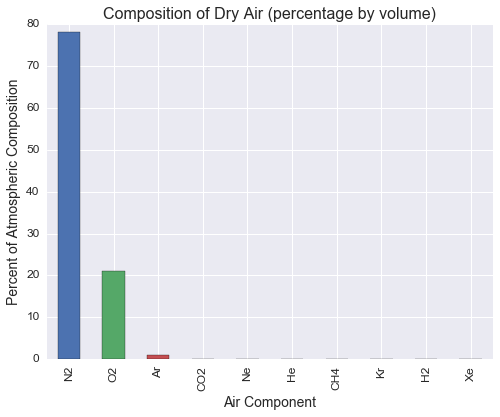

In [41]:
ax = air_comp['pct_vol'].plot(kind='bar', figsize=(8,6))
ax.set_ylabel('Percent of Atmospheric Composition', fontsize=14)
ax.set_xlabel('Air Component', fontsize=14)
ax.set_title('Composition of Dry Air (percentage by volume)', fontsize=16)
ax.tick_params(labelsize=12)

This table was made in 2003, and for most engineering tables, the values are essentially constant, but I see that CO2 has a percent volume of 0.033% and I know from independent sources that [CO2 concentrations have increased to values above 400 parts per million by volume](https://www.theguardian.com/environment/2015/may/06/global-carbon-dioxide-levels-break-400ppm-milestone) (ppmv), or over 0.04%.

In [33]:
TXT_PATH = os.path.join('data', 'weather', 'mlo', 'co2_mlo_surface-insitu_1_ccgg_MonthlyData.txt')
names = ['site_code','year', 'month', 'day', 'hour', 'minute', 'second',
         'value',          'value_unc', 'nvalue','latitude','longitude',
         'altitude', 'elevation', 'intake_height', 'instrument', 'qcflag']
mlo_co2 = pd.read_table(TXT_PATH,
                        header=None, 
                        skiprows=169,
                        delim_whitespace=True)
mlo_co2.columns = names
mlo_co2.head()

,site_code,year,month,day,hour,minute,second,value,value_unc,nvalue,latitude,longitude,altitude,elevation,intake_height,instrument,qcflag
0,MLO,1974,5,1,0,0,0,333.16,0.34,14,19.536,-155.576,3437.0,3397.0,40.0,NaN,...
1,MLO,1974,6,1,0,0,0,332.11,0.46,26,19.536,-155.576,3437.0,3397.0,40.0,NaN,...
2,MLO,1974,7,1,0,0,0,331.11,0.49,24,19.536,-155.576,3437.0,3397.0,40.0,NaN,...
3,MLO,1974,8,1,0,0,0,329.09,0.64,27,19.536,-155.576,3437.0,3397.0,40.0,NaN,...
4,MLO,1974,9,1,0,0,0,327.27,0.63,24,19.536,-155.576,3437.0,3397.0,40.0,NaN,...


In [18]:
TXT_PATH = os.path.join('data', 'weather', 'nasa_msis_atmosphere_composition_data_12_08.txt')
names = ['Height [km]', 'O, cm-3', 'N2, cm-3', 'O2, cm-3', 'Mass Density', 
         'Temperature_neutral', 'Temperature_exospheric', 'He, cm-3',
         'Ar, cm-3', 'H, cm-3','N, cm-3', 'F10_7_daily']
atmos_comp = pd.read_table(TXT_PATH, 
                           header=None, 
                           skiprows=39,
                           delim_whitespace=True)

atmos_comp.columns = names
atmos_comp.drop(['Temperature_neutral', 'Temperature_exospheric', 'Mass Density', 'F10_7_daily'], axis=1, inplace=True)
atmos_comp.set_index('Height [km]', inplace=True)
atmos_comp.head()

,"O, cm-3","N2, cm-3","O2, cm-3","He, cm-3","Ar, cm-3","H, cm-3","N, cm-3"
Height [km],,,,,,,
0.0,0.0,2.053000e+19,5.508000e+18,1.378000e+14,2.456000e+17,0.0,0.0
1.0,0.0,1.839000e+19,4.932000e+18,1.234000e+14,2.199000e+17,0.0,0.0
2.0,0.0,1.655000e+19,4.440000e+18,1.111000e+14,1.980000e+17,0.0,0.0
3.0,0.0,1.494000e+19,4.008000e+18,1.003000e+14,1.787000e+17,0.0,0.0
4.0,0.0,1.349000e+19,3.619000e+18,9.053000e+13,1.614000e+17,0.0,0.0


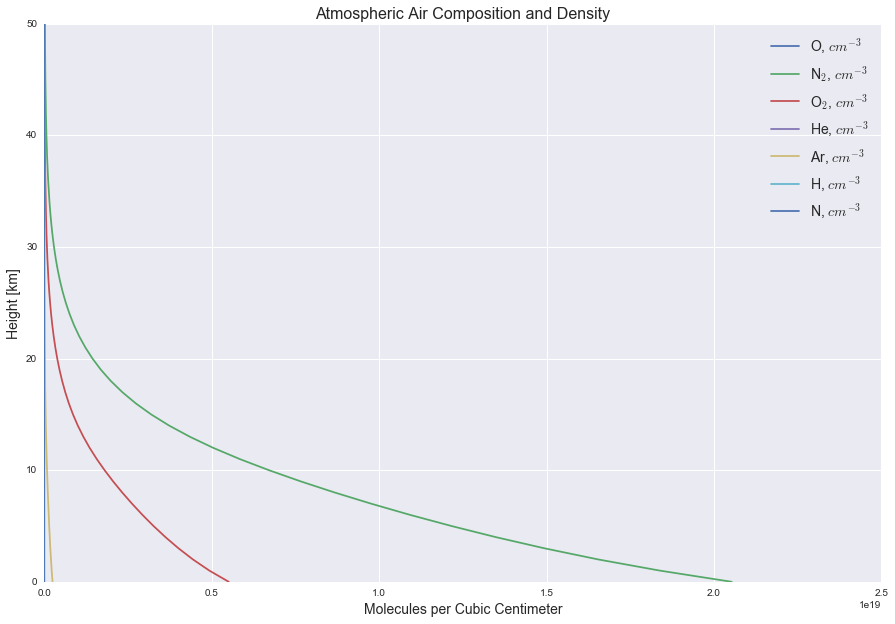

In [19]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.plot(atmos_comp['O, cm-3'].values, atmos_comp['O, cm-3'].index, label='O, $cm^{-3}$')
ax.plot(atmos_comp['N2, cm-3'].values, atmos_comp['N2, cm-3'].index, label='N$_2$, $cm^{-3}$')
ax.plot(atmos_comp['O2, cm-3'].values, atmos_comp['O2, cm-3'].index, label='O$_2$, $cm^{-3}$')
ax.plot(atmos_comp['He, cm-3'].values, atmos_comp['He, cm-3'].index, label='He, $cm^{-3}$')
ax.plot(atmos_comp['Ar, cm-3'].values, atmos_comp['Ar, cm-3'].index, label='Ar, $cm^{-3}$')
ax.plot(atmos_comp['H, cm-3'].values, atmos_comp['H, cm-3'].index, label='H, $cm^{-3}$')
ax.plot(atmos_comp['N, cm-3'].values, atmos_comp['N, cm-3'].index, label='N, $cm^{-3}$')
ax.set(ylim=[0, 50])
ax.set_ylabel('Height [km]', fontsize=14)
ax.set_xlabel('Molecules per Cubic Centimeter', fontsize=14)
ax.set_title('Atmospheric Air Composition and Density', fontsize=16)
ax.legend(fontsize=14)
plt.show()

In [26]:
print('At a height of 0 km, N2 makes up {:2.6}% of the dry atmosphere at that height'
      .format(atmos_comp.loc[0,'N2, cm-3'] * 100 / (atmos_comp.loc[0,:].sum()+0.0407)))
print('At a height of 0 km, O2 makes up {:2.6}% of the dry atmosphere at that height'
      .format(atmos_comp.loc[0,'O2, cm-3'] * 100 / (atmos_comp.loc[0,:].sum()+0.0407)))
print('At a height of 0 km, Ar makes up {:2.6}% of the dry atmosphere at that height'
      .format(atmos_comp.loc[0,'Ar, cm-3'] * 100 / (atmos_comp.loc[0,:].sum()+0.0407)))
print('At a height of 0 km, He makes up {:2.6}% of the dry atmosphere at that height'
      .format(atmos_comp.loc[0,'He, cm-3'] * 100 / (atmos_comp.loc[0,:].sum()+0.0407)))

At a height of 0 km, N2 makes up 78.1091% of the dry atmosphere at that height
At a height of 0 km, O2 makes up 20.9559% of the dry atmosphere at that height
At a height of 0 km, Ar makes up 0.934418% of the dry atmosphere at that height
At a height of 0 km, He makes up 0.000524279% of the dry atmosphere at that height


ftp://aftp.cmdl.noaa.gov/data/greenhouse_gases/co2/in-situ/surface/

ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt

https://www.engineeringtoolbox.com/air-composition-d_212.html

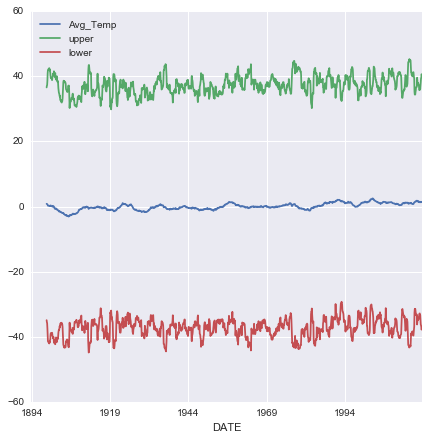

In [22]:
moving_avg = temp_chi.rolling(window=60).mean()
span_avg = moving_avg['Avg_Temp'].mean()
moving_avg = moving_avg - span_avg
moving_std = temp_chi.rolling(window=12).std()
moving_avg['upper'] = moving_avg['Avg_Temp'] + (2 * moving_std['Avg_Temp']) 
moving_avg['lower'] = moving_avg['Avg_Temp'] - (2 * moving_std['Avg_Temp'])
moving_avg.plot(figsize=(7,7))

In [23]:
# sns.lmplot(data=moving_avg,
#            x=moving_avg.index,
#            y='Avg_Temp')

In [24]:
ma = co2_levels.rolling(window=52).mean()
mstd = co2_levels.rolling(window=52).std()
ma['upper'] = ma['co2'] + (2 * mstd['co2'])
ma['lower'] = ma['co2'] - (2 * mstd['co2'])
ax = ma.plot(linewidth=0.8, fontsize=6, figsize=(8,6), color=['black', '#ca0020', '#0571b0'])

# Specify labels, legend, and show the plot
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('CO2 levels in Mauai Hawaii', fontsize=12)
ax.tick_params(labelsize=12)
ax.set_title('Rolling mean and variance of CO2 levels\nin Mauai Hawaii from 1958 to 2001', fontsize=14)
ax.legend(fontsize=14, loc='best')
plt.show()

NameError: name 'co2_levels' is not defined